# Лабораторная работа 4
## Аппроксимации граничных условий второго рода в методе конечных разностей на примере уравнения теплопроводности

### Исходное уравнение:

$$
\begin{cases} \frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2} + f(x, t),\\ u(a, t) = g_1(t), \\ \frac{\partial u}{\partial t}(b, t) = g_2(t), \\ u(x, 0) = \phi(x). \end{cases}
$$



In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import integrate
import pylab

a = -1
b = 1 
k = 0.5
T = 0.4
phi = abs
g_1 = lambda t: 1
g_2 = lambda t: 1
f = lambda x, t: 0

## Явная схема

### 1 способ:

Формула явной схемы с лабораторной работы 3:

$$
u(x, t + \tau) = \frac{k \cdot \tau}{h^2}u(x-h,t) + (1 - \frac{2 k \cdot \tau}{h^2})u(x,t) + \frac{k \cdot \tau}{h^2}u(x+h, t) + \tau f(x, t)
$$ 

Граничное условие второго рода:

$$
\frac{\partial u}{\partial x}(b, t) = g_2(t)
$$

Аппроксимируем его следующим образом:

$$
\frac{\partial u}{\partial x} = \frac{u_N^n - u_{N-1}^n}{h}
$$

Получаем:

$$
u_N^n = h * g_2(t) + u_{N-1}^n
$$

In [2]:
def explicit_1(h, dt):
    nt = int(T / dt) + 1
    nx = int((b - a) / h) + 1
    x_values = np.linspace(a, b, nx)
    t_values = np.linspace(0, dt, nt)
    A = np.zeros((nt, nx))
    A[0] = [phi(x) for x in x_values]
    A[:, 0] = [g_1(t) for t in t_values]
    
    for i in range(nt - 1):
        for j in range(1, nx - 1):            
            A[i + 1, j] = k * dt / h ** 2 * A[i, j-1] + (1 - 2 * k * dt / h ** 2) * A[i, j] + \
                          k * dt / h ** 2 * A[i, j + 1] + dt * f(x_values[j], t_values[i])
        A[i + 1, -1] = A[i + 1, -2] + h * g_2(t_values[i])
    return x_values, t_values, A

def show_plots(x, A):
    for i in range(0, len(A), 100):
        plt.plot(x, A[i])
    plt.grid()
    plt.xlabel('x', size=14)
    plt.ylabel('u(x, t)', size=14)
    plt.show()

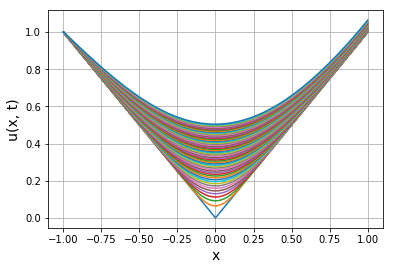

In [3]:
N = 100
h = (b - a) / N
dt = h ** 2 / 6

x_row, t_row, A = explicit_1(h, dt)
show_plots(x_row, A)

### 2 способ:


Аппроксимируем граничное условие второго рода с добавлением фиктивных узлов:

$$
\frac{\partial u}{\partial x} = \frac{u_{N + 1}^n - u_{N-1}^n}{2h}
$$

Выражаем фиктивный узел:

$$
u_{N+1}^n = 2h g_2(t) + u_{N-1}^n
$$

Подставив в исходную формулу, получаем:

$$
u(b, t + \tau) = \frac{k \tau}{h^2}u(b-h,t) + (1 - \frac{2k \tau}{h^2})u(b,t) + \frac{k \tau}{h^2}(
2h g_2(t) + T_{N-1}^n) + \tau f(x, t)
$$

In [4]:
def explicit_2(h, dt):
    nt = int(T / dt) + 1
    nx = int((b - a) / h) + 1
    x_values = np.linspace(a, b, nx)
    t_values = np.linspace(0, dt, nt)
    A = np.zeros((nt, nx))
    A[0] = [phi(x) for x in x_values]
    A[:, 0] = [g_1(t) for t in t_values]
    
    for i in range(nt - 1):
        for j in range(1, nx - 1):            
            A[i + 1, j] = k * dt / h ** 2 * A[i, j - 1] + (1 - 2 * k * dt / h ** 2) * A[i, j] + \
                          k * dt / h ** 2 * A[i, j + 1] + dt * f(x_values[j], t_values[i])
        A[i + 1, -1] = k * dt / h ** 2 * A[i, -2] + (1 - 2 * k * dt / h ** 2) * A[i, -1] + k * dt / h ** 2 * \
                        (2 * h * g_2(t_values[i]) + A[i + 1, -2]) + dt * f(x_values[j], t_values[i])
    return x_values, t_values, A

101


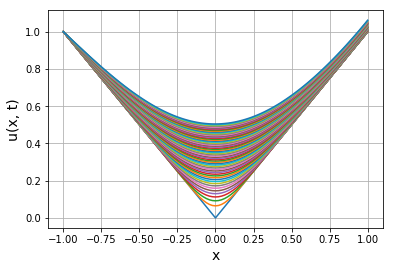

In [5]:
x_row, t_row, A = explicit_2(h, dt)
print(len(x_row))
show_plots(x_row, A)

## Неявная схема

###  1 способ

Граничное условие:

$$
\frac{\partial u}{\partial x}(b, t) = g_2(t)
$$

Аппроксимируем его следующим образом:

$$
\frac{\partial u}{\partial x} = \frac{u_N^n - u_{N-1}^n}{h}
$$

Получаем:

$$
u_N^n - u_{N-1}^n = h * g_2(t)
$$

Формула неявной схемы:

$$
-\frac{k\tau}{h^2}u(x-h,t+\tau) + (1 + \frac{2k\tau}{h^2})u(x,t+\tau) - \frac{k\tau}{h^2}u(x+h, t+\tau) = u(x, t) + \tau f(x, t+\tau)
$$ 

На каждом слое решаем систему, коэффициенты матрицы, а также свободные члены берем исходя из формулы неявной схемы. Коэффициенты последней строки матрицы берем из аппроксимации граничного условия второго рода. Первой строки - из граничных условий первого рода.

In [6]:
def implicit_1(h, dt):
    nt = int(T / dt) + 1
    nx = int((b - a) / h) + 1
    x_values = np.linspace(a, b, nx)
    t_values = np.linspace(0, dt, nt)
    A = np.zeros((nt, nx))
    A[0] = [phi(x) for x in x_values]
    A[:, 0] = [g_1(t) for t in t_values]
    
    matrix = np.zeros((nx, nx))
    for j in range(1, nx - 1):
            matrix[j, j-1] = - k * dt / h ** 2 
            matrix[j, j] = 1 + 2 * k * dt / h ** 2
            matrix[j, j+1] = - k * dt / h ** 2
    matrix[0, 0] = 1
    matrix[-1, -1], matrix[-1, -2] = 1, -1 
    
    for i in range(1, nt):
        free_members = np.array([dt * f(x, t_values[i] + dt) for x in x_values]) + A[i - 1]
        free_members[0] = g_1(t_values[i])
        free_members[-1] = h * g_2(t_values[i])
        A[i] = np.linalg.solve(matrix, free_members)
    return x_values, t_values, A

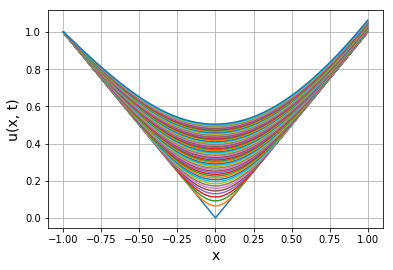

In [7]:
x_row, t_row, A = implicit_1(h, dt)
show_plots(x_row, A)

### 2 способ

Используя фиктивные узлы и формулу неявной схемы:

$$
u_{N+1}^n - u_{N-1}^n = 2h g_2(t)
\\
-\frac{k\tau}{h^2}u(x-h,t+\tau) + (1 + \frac{2k\tau}{h^2})u(x,t+\tau) - \frac{k\tau}{h^2}u(x+h, t+\tau) = u(x, t) + \tau f(x, t+\tau)
$$ 

Находим коэффициенты матрицы. На каждом слое решаем систему.


In [8]:
def implicit_2(h, dt):
    nt = int(T / dt) + 1
    nx = int((b - a) / h) + 1
    x_values = np.linspace(a, b, nx)
    t_values = np.linspace(0, dt, nt)
    A = np.zeros((nt, nx))
    A[0] = [phi(x) for x in x_values]
    A[:, 0] = [g_1(t) for t in t_values]
    
    matrix = np.zeros((nx + 1, nx + 1))
    for j in range(1, nx):
        matrix[j, j-1] = - k * dt / h ** 2 
        matrix[j, j] = 1 + 2 * k * dt / h ** 2
        matrix[j, j+1] = - k * dt / h ** 2
    matrix[0, 0] = 1
    matrix[-1, -1], matrix[-1, -3] = 1, -1 
    
    for i in range(1, nt):
        free_members = np.zeros(nx + 1)
        free_members[1:-1] = np.array([dt * f(x, t_values[i] + dt) for x in x_values[1:]]) + A[i - 1, 1:]
        free_members[0] = g_1(t_values[i])
        free_members[-1] = 2 * h * g_2(t_values[i])
        A[i] = np.linalg.solve(matrix, free_members)[:-1]
    return x_values, t_values, A

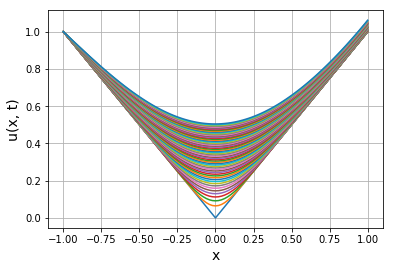

In [9]:
N = 100
h = (b - a) / N
dt = (((b - a) / N) ** 2) / 6
x_row, t_row, A = implicit_2(h, dt)
show_plots(x_row, A)

## Анализ сходимости методов

### Фиксированное h

In [10]:
import pandas as pd

def fixed_h_statistics(t1, t2, n, h, dt, method):
    columns = ['h', 'dt', 'std(t=t1)', 'std(t=t2)', 'max(t=t1)', 'max(t=t2)']
    rows = []
    for i in range(n):
        i1 = int(t1/dt)
        i2 = int(t2/dt)
        _, _, A = method(h, dt)
        _, _, B = method(h, dt / 2)
        diff1, diff2 = A[i1] - B[2*i1], A[i2] - B[2*i2]
        max_diff1 = max(abs(diff1))
        max_diff2 = max(abs(diff2))
        rows.append([h, dt, diff1.std(), diff2.std(), max_diff1, max_diff2])
        dt /= 2
    return pd.DataFrame(rows, columns=columns)

In [31]:
t1 = 0.1
t2 = 0.3
h = 0.1
dt = 0.01

### Явная схема. 1 метод

In [32]:
fixed_h_statistics(t1, t2, 5, h, dt, explicit_1)

,h,dt,std(t=t1),std(t=t2),max(t=t1),max(t=t2)
0,0.1,0.010000,0.003363,0.002438,0.007425,0.004462
1,0.1,0.005000,0.000368,0.000274,0.000823,0.000457
2,0.1,0.002500,0.000182,0.000136,0.000411,0.000228
3,0.1,0.001250,0.000091,0.000068,0.000205,0.000114
4,0.1,0.000625,0.000045,0.000034,0.000103,0.000057


### Явная схема. 2 метод

In [33]:
fixed_h_statistics(t1, t2, 5, h, dt, explicit_2)

,h,dt,std(t=t1),std(t=t2),max(t=t1),max(t=t2)
0,0.1,0.010000,0.003363,0.002426,0.007425,0.004470
1,0.1,0.005000,0.000366,0.000185,0.000823,0.000527
2,0.1,0.002500,0.000181,0.000092,0.000411,0.000254
3,0.1,0.001250,0.000090,0.000046,0.000205,0.000124
4,0.1,0.000625,0.000045,0.000023,0.000103,0.000062


### Неявная схема. 1 метод

In [34]:
fixed_h_statistics(t1, t2, 5, h, dt, implicit_1)

,h,dt,std(t=t1),std(t=t2),max(t=t1),max(t=t2)
0,0.1,0.010000,0.000693,0.000534,0.001634,0.000909
1,0.1,0.005000,0.000353,0.000269,0.000819,0.000455
2,0.1,0.002500,0.000179,0.000135,0.000410,0.000228
3,0.1,0.001250,0.000090,0.000068,0.000205,0.000114
4,0.1,0.000625,0.000045,0.000034,0.000103,0.000057


### Неявная схема. 2 метод

In [35]:
fixed_h_statistics(t1, t2, 5, h, dt, implicit_2)

,h,dt,std(t=t1),std(t=t2),max(t=t1),max(t=t2)
0,0.1,0.010000,0.000689,0.000525,0.001634,0.000920
1,0.1,0.005000,0.000351,0.000265,0.000819,0.000460
2,0.1,0.002500,0.000178,0.000133,0.000410,0.000230
3,0.1,0.001250,0.000089,0.000067,0.000205,0.000115
4,0.1,0.000625,0.000045,0.000033,0.000103,0.000058


### Фиксированное $\tau$

In [36]:
def fixed_dt_statistics(t1, t2, n, h, dt, method):
    columns = ['h', 'dt', 'std(t=t1)', 'std(t=t2)', 'max(t=t1)', 'max(t=t2)']
    rows = []
    for i in range(n):
        i1 = int(t1/dt)
        i2 = int(t2/dt)
        _, _, A = method(h, dt)
        _, _, B = method(h / 2, dt)
        diff1, diff2 = A[i1] - B[i1, ::2], A[i2] - B[i2, ::2]
        max_diff1 = max(abs(diff1))
        max_diff2 = max(abs(diff2))
        rows.append([h, dt, diff1.std(), diff2.std(), max_diff1, max_diff2])
        h /= 2
    return pd.DataFrame(rows, columns=columns)

In [37]:
t1, t2 = 0.2, 0.3
T = 0.4
h = 0.2
dt = 0.00001

### Явная схема. 1 метод

In [38]:
fixed_dt_statistics(t1, t2, 5, h, dt, explicit_1)

,h,dt,std(t=t1),std(t=t2),max(t=t1),max(t=t2)
0,0.2000,0.00001,0.003735,0.004864,0.007046,0.011679
1,0.1000,0.00001,0.000963,0.001498,0.002101,0.004556
2,0.0500,0.00001,0.000283,0.000543,0.000830,0.001979
3,0.0250,0.00001,0.000097,0.000224,0.000364,0.000918
4,0.0125,0.00001,0.000038,0.000101,0.000170,0.000441


### Явная схема. 2 метод

In [39]:
fixed_dt_statistics(t1, t2, 5, h, dt, explicit_2)

,h,dt,std(t=t1),std(t=t2),max(t=t1),max(t=t2)
0,0.2000,0.00001,0.002680,0.002090,0.007060,0.005651
1,0.1000,0.00001,0.000647,0.000498,0.001693,0.001377
2,0.0500,0.00001,0.000160,0.000121,0.000419,0.000342
3,0.0250,0.00001,0.000039,0.000029,0.000105,0.000085
4,0.0125,0.00001,0.000009,0.000006,0.000026,0.000026


### Неявная схема. 1 метод

In [40]:
fixed_dt_statistics(t1, t2, 5, h, dt, implicit_1)

,h,dt,std(t=t1),std(t=t2),max(t=t1),max(t=t2)
0,0.2000,0.00001,0.003735,0.004864,0.007047,0.011679
1,0.1000,0.00001,0.000963,0.001498,0.002101,0.004556
2,0.0500,0.00001,0.000283,0.000543,0.000830,0.001979
3,0.0250,0.00001,0.000097,0.000224,0.000364,0.000918
4,0.0125,0.00001,0.000038,0.000101,0.000170,0.000441


### Неявная схема. 2 метод

In [41]:
fixed_dt_statistics(t1, t2, 5, h, dt, implicit_2)

,h,dt,std(t=t1),std(t=t2),max(t=t1),max(t=t2)
0,0.2000,0.00001,0.002680,0.002090,0.007060,0.005651
1,0.1000,0.00001,0.000647,0.000498,0.001693,0.001377
2,0.0500,0.00001,0.000160,0.000122,0.000419,0.000342
3,0.0250,0.00001,0.000040,0.000030,0.000105,0.000085
4,0.0125,0.00001,0.000010,0.000008,0.000026,0.000021
